# Determine sky position of source using a Bayesian method

- Amplitude measurement is good.
- Phase measurement is jittery --> add some jitter to phase in compute response.

What amount of phase accuracy do we need for a decent skymap?

## Read in fits data

In [1]:
import numpy as np

In [2]:
def dual_band_network_response_analyzer(fits,fits2,f_gw1,f_gw2):
        
        fit_S = []
        fit_S2 = []

        for fit in fits:
            fit_S.append(fit['amplitude']*np.exp(1j*fit['phase']))

        for fit in fits2:
            fit_S2.append(fit['amplitude']*np.exp(1j*fit['phase']))

        phases_1 = []
        phases_1_err = []
        phases_2 = []
        phases_2_err = []
        rel_amp_1_err = []

        for fit in fit_S:
            phases_1.append(np.angle(fit))
        for fit in fits:
            phases_1_err.append(fit['phase_err'])

        for fit in fit_S2:
            phases_2.append(np.angle(fit))
        for fit in fits2:
            phases_2_err.append(fit['phase_err'])


        for fit in fits:
            rel_amp_1_err.append(np.abs(fit['amplitude_err']/fit['amplitude']))

        phases_1 = np.array(phases_1)
        phases_1_err = np.array(phases_1_err)
        phases_2 = np.array(phases_2)
        phases_2_err = np.array(phases_2_err)

        phase_delay_diff = np.angle(np.array(fit_S)/np.array(fit_S2))
        phase_delay_err = np.sqrt(phases_1_err**2+phases_2_err**2)
        time_delay = (phase_delay_diff-phase_delay_diff[0])/(2*np.pi*(f_gw2-f_gw1))
        time_delay_err = phase_delay_err/(2*np.pi*(f_gw2-f_gw1))
        antenna_response = fit_S/fit_S[0]/(np.exp(-1j*2*np.pi*f_gw1*time_delay))
        
        antenna_response_amp = np.abs(antenna_response)
        antenna_response_amp_err = np.abs(antenna_response)*np.array(rel_amp_1_err)
        
        antenna_response_phase = np.angle(antenna_response)
        antenna_response_phase_err = np.array(phases_1_err)
        
        
        return (antenna_response_amp,antenna_response_amp_err,antenna_response_phase,antenna_response_phase_err,time_delay,time_delay_err)
    

In [3]:
import json

In [4]:
json_file_name = "data.json"

In [5]:
with open(json_file_name, 'r') as file:
    data = json.load(file)

In [6]:
data.keys()

dict_keys(['fits1', 'fits2', 'T_1', 'T_2'])

In [7]:
data['fits1']

[{'amplitude': 1.2971321875050799e-21,
  'frequency': 0.010131550912418732,
  'phase': -1.0670349331526325,
  'offset': 1.0902856778599896e-23,
  'amplitude_err': 2.0804463321415517e-23,
  'frequency_err': 0.00020816950593062356,
  'phase_err': 0.06341750064404633,
  'offset_err': 2.3800212914221513e-23},
 {'amplitude': 1.1701612882120962e-21,
  'frequency': 0.009847311040593618,
  'phase': 0.6490023769562426,
  'offset': 2.795009123578027e-23,
  'amplitude_err': 4.03426450543411e-23,
  'frequency_err': 0.00010557228398298297,
  'phase_err': 0.04967643838047338,
  'offset_err': 2.737120620623297e-23},
 {'amplitude': 1.472105376733001e-21,
  'frequency': 0.010325213198885764,
  'phase': 0.8319328465070046,
  'offset': 5.112895135747485e-24,
  'amplitude_err': 4.9032913555003505e-23,
  'frequency_err': 0.000146529774915561,
  'phase_err': 0.05158025154367791,
  'offset_err': 3.222583269856228e-23}]

In [8]:
##Measurement Cycles
f_gw1 = 1/100 ##Keep this in the 10s of mHz 

f_gw2 = 2/100 ## Select this such that T_12 is not more than 10 days?

In [9]:
antenna_response_amp,antenna_response_amp_err,antenna_response_phase,antenna_response_phase_err,time_delay,time_delay_err  = dual_band_network_response_analyzer(data['fits1'],data['fits2'],f_gw1,f_gw2)

In [10]:
antenna_response_amp,antenna_response_amp_err,antenna_response_phase,antenna_response_phase_err,time_delay,time_delay_err

(array([1.        , 0.90211414, 1.13489233]),
 array([0.01603882, 0.03110141, 0.03780102]),
 array([ 3.85627779e-17, -2.79048048e+00, -2.20499474e+00]),
 array([0.0634175 , 0.04967644, 0.05158025]),
 array([ 0.        , 28.27654183, 34.68340781]),
 array([2.88241052, 2.77798241, 2.20523242]))

# BAYESIAN SKY LOC INFERENCE

In [11]:
import bilby
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from bilby.core.utils import random

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

f0 = 429e12
h_const = lal.H_SI
G = lal.G_SI
c = lal.C_SI
M0 = lal.MSUN_SI

# Detector Network

In [12]:
N_detectors = 3

theta_1 = 0
theta_2 = np.pi/3
theta_3 = np.pi/6

r = 1.46e11 #metres

detector_positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
detector_arms = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])

# Measurement frequency and Chirp Mass

In [13]:
f_gw=0.01
Mc = 1000*M0

# GW MODEL

In [14]:
def compute_complex_response(f_gw, ra, dec, A, iota, psi):
    
    theta, phi = bilby.core.utils.conversion.ra_dec_to_theta_phi(ra, dec, 0)

    #A = f_gw**(-7/6) * (1./dL) * (5./(24 * np.pi ** (4/3))) * ((G * Mc) **(5./6.))/c**(3./2.)

    A_plus = A * (1+np.cos(iota)**2)/2
    A_cross = A * np.cos(iota)

    # GW propagation vector
    k = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', detector_arms, detector_arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
    
    tau_model = np.dot(detector_positions, k)/c
    #print(tau_model)

    # Complex response including time delay
    S_model = (F_plus*A_plus + F_cross*A_cross * np.exp(1j*np.pi/2)) * np.exp(-1j*2*np.pi*f_gw*tau_model)
    #print(S_model)

    return S_model, tau_model

# LIKELIHOOD CLASS

In [15]:
class GWNetworkLikelihood(bilby.likelihood.Likelihood):
    def __init__(self, data_S, error_S, data_tau, error_tau, model):
        self.data_S = data_S  # Complex array of measured strain
        self.error_S = error_S # Real array of strain errors (assuming equal Re/Im error)
        self.data_tau = data_tau # Real array of measured time delay
        self.error_tau = error_tau # Real array of time delay errors
        self.model = model # The gw_network_model function

        super().__init__(parameters={'ra': None, 'dec': None, 
                                     'A': None, 'iota': None,
                                     'psi': None
                                     })

    def log_likelihood(self):
        """
        Calculates the total log-likelihood for the current set of parameters (theta).
        """
        try:
            S_model, tau_model = self.model(f_gw, **self.parameters)
        except Exception as e:
            # Handle potential numerical errors by returning a very small likelihood
            print(f"Model calculation failed: {e}")
            return -np.inf
        
        # --- Likelihood from Time Delay (ln L_tau) ---
        # Delta_tau = tau_meas - tau_model
        delta_tau = self.data_tau - tau_model
        
        # Time delay variance --> Put in measured error
        sigma_tau_sq = self.error_tau**2
        
        # Log-Likelihood calculation
        ln_L_tau = -0.5 * np.sum((delta_tau**2 / sigma_tau_sq) + np.log(2 * np.pi * sigma_tau_sq))
        
        # --- Likelihood from Complex Strain (ln L_S) ---
        # Delta_S = S_meas - S_model (complex)
        delta_S = self.data_S - S_model

        delta_S_re = np.real(delta_S)
        delta_S_im = np.imag(delta_S)
        
        # Assume errors are equal for real and imaginary components
        sigma_S_sq = self.error_S**2
        
        # Log-Likelihood calculation for Re/Im parts
        ln_L_S_re = -0.5 * np.sum((delta_S_re**2 / sigma_S_sq) + np.log(2 * np.pi * sigma_S_sq))
        ln_L_S_im = -0.5 * np.sum((delta_S_im**2 / sigma_S_sq) + np.log(2 * np.pi * sigma_S_sq))
        
        ln_L_S = ln_L_S_re + ln_L_S_im
        
        # --- Total Log-Likelihood ---
        ln_L_total = ln_L_S
        
        return ln_L_total

# SETUP

In [16]:
label = "gw_localization"
outdir = "outdir_ra_dec_A_iota_psi_0002"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)
random.seed(123)
rng = np.random.default_rng(123) # Use a modern random number generator

# INJECTION

In [17]:
def get_dL(Mc, A, f_gw):
    "get dL in Mpc; A from https://arxiv.org/pdf/2507.10597"
    return f_gw**(-7/6) * (1./A) * (5./(24 * np.pi ** (4/3))) * ((G * Mc*2e30) **(5./6.))/c**(3./2.) * 3.2407792896664e-26

In [18]:
get_dL(1000, 1e-20, 0.01)

113.72093774039392

In [19]:
injection_parameters = dict(
    ra=0.5,                 # Right Ascension (rad)
    dec=0.7,                # Declination (rad)
    psi=np.pi/3,               # Polarization angle (rad)
    A  = 1e-20,
    iota = np.pi/3
)
#time_delay_ref=0.0  # Reference time delay

# GENERATE DATA

In [20]:
S_true, tau_true = compute_complex_response(f_gw, **injection_parameters)
print(S_true)
print(tau_true)

#Errors
sigma_S = np.ones(N_detectors) * 1e-22   # Strain error --> use different for real and im parts
sigma_tau = np.array([2.88241052, 2.77798241, 2.20523242]) # Time delay error (seconds)
print(sigma_S)
print(sigma_tau)

# Add Gaussian Noise to the true values to simulate measurements
data_S = S_true + rng.normal(0, sigma_S, N_detectors) + 1j * rng.normal(0, sigma_S, N_detectors)
data_tau = tau_true + rng.normal(0, sigma_tau, N_detectors)
print(data_S)
print(data_tau)

[-4.80238159e-22+2.59620977e-21j  1.08572549e-21-1.19553373e-22j
 -5.28189827e-22-1.60782856e-21j]
[326.88272718 318.09345027 372.37716967]
[1.e-22 1.e-22 1.e-22]
[2.88241052 2.77798241 2.20523242]
[-5.79150294e-22+2.61560722e-21j  1.04894682e-21-2.75302829e-23j
 -3.99397301e-22-1.55011818e-21j]
[325.04817767 319.598984   371.67900312]


# Instantiate Likelihood

In [21]:
likelihood = GWNetworkLikelihood(
    data_S=data_S, 
    error_S=sigma_S, 
    data_tau=data_tau, 
    error_tau=sigma_tau, 
    model=compute_complex_response
)

# PRIORS

In [22]:
# Define Priors (We want to sample the full sky)
priors = bilby.core.prior.PriorDict()
priors["dec"] = bilby.core.prior.Cosine(name='dec')
priors["ra"] = bilby.core.prior.Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic')
priors["psi"] = bilby.core.prior.Uniform(0, np.pi, "psi", latex_label=r"\psi")
priors["iota"] = bilby.core.prior.Sine(name=r"\iota")
priors["A"] = bilby.core.prior.LogUniform(1e-21, 1e-19, "A_plus", latex_label=r"A_+")
#priors["A_cross"] = bilby.core.prior.LogUniform(1e-22, 1e-20, "A_cross", latex_label=r"A_\times")
#priors["f_gw"] = injection_parameters["f_gw"] # Fix frequency for simplicity
#priors["time_delay_ref"] = 0 # Fix reference time delay

# RUN SAMPLER

In [23]:
print("Starting BILBY sampler for GW localization...")
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=500,  # Increased nlive for better sky sampling
    nact=5,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    seed=123,
    result_class=bilby.gw.result.CBCResult #bilby.core.result.Result
)

# Finally plot a corner plot
result.plot_corner()

print(f"\nSampling complete. Results saved to {outdir}/{label}_result.json")

13:05 bilby INFO    : Running for label 'gw_localization', output will be saved to 'outdir_ra_dec_A_iota_psi_0002'


Starting BILBY sampler for GW localization...


13:05 bilby INFO    : Analysis priors:
13:05 bilby INFO    : dec=Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
13:05 bilby INFO    : ra=Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic')
13:05 bilby INFO    : psi=Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_label='\\psi', unit=None, boundary=None)
13:05 bilby INFO    : iota=Sine(minimum=0, maximum=3.141592653589793, name='\\iota', latex_label='\\iota', unit=None, boundary=None)
13:05 bilby INFO    : A=LogUniform(minimum=1e-21, maximum=1e-19, name='A_plus', latex_label='A_+', unit=None, boundary=None)
13:05 bilby INFO    : Analysis likelihood class: <class '__main__.GWNetworkLikelihood'>
13:05 bilby INFO    : Analysis likelihood noise evidence: nan
13:05 bilby INFO    : Single likelihood evaluation took 1.276e-04 s
13:05 bilby WARNING : Kwargs contain both 'rstate' 

5487it [00:00, ?it/s]

13:06 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
13:17 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
13:43 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
14:05 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
14:24 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
14:34 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
14:45 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
14:55 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
15:06 bilby INFO    : Written checkpoint file outdir_ra_dec_A_iota_psi_0002/gw_localization_resume.pickle
15:13 bilby INFO    : Written checkpoint file 



Sampling complete. Results saved to outdir_ra_dec_A_iota_psi_0002/gw_localization_result.json


In [28]:
import matplotlib.pyplot as plt

import json

results_name = "outdir_ra_dec_A_iota_psi_0002/gw_localization_result.json"

with open(results_name, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['label', 'outdir', 'sampler', 'log_evidence', 'log_evidence_err', 'log_noise_evidence', 'log_bayes_factor', 'priors', 'posterior', 'injection_parameters', 'meta_data', 'search_parameter_keys', 'fixed_parameter_keys', 'constraint_parameter_keys', 'sampling_time', 'sampler_kwargs', 'use_ratio', 'information_gain', 'log_likelihood_evaluations', 'log_prior_evaluations', 'num_likelihood_evaluations', 'samples', 'nested_samples', 'parameter_labels', 'parameter_labels_with_unit', 'version'])


In [29]:
data['search_parameter_keys']

['dec', 'ra', 'psi', 'iota', 'A']

In [30]:
from operator import itemgetter

dec_samples = list(map(itemgetter(0), data['samples']['content']))
ra_samples = list(map(itemgetter(1), data['samples']['content']))

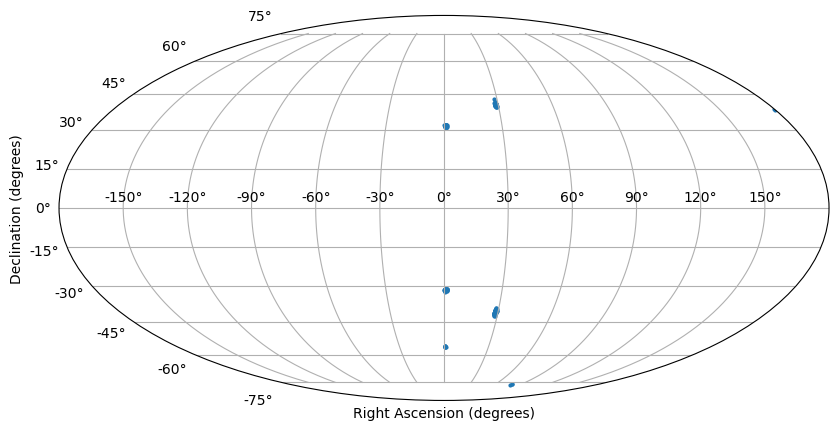

<Figure size 640x480 with 0 Axes>

In [32]:
def plot_mwd_radec(RA, Dec, name='skymap_0001.png', org=0):
    """
    Creates a Mollweide projection plot from RA and Dec samples.
    RA values should be in [0, 360), Dec in [-90, 90], in degrees.
    org sets the central longitude (e.g., 0 or 180 for the galactic center).
    """

    x_rad = RA
    Dec_rad = Dec

    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(111, projection='mollweide')
    
    ax.scatter(x_rad, Dec_rad, s=4, alpha=1)

    ax.set_xlabel("Right Ascension (degrees)")
    ax.set_ylabel("Declination (degrees)")
    ax.grid(True)
    plt.show()
    plt.savefig(name)

plot_mwd_radec(ra_samples, dec_samples)
